In [3]:
#!/usr/bin/env python3
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from train import *
from visual_functions import *
%matplotlib inline

## ---------------------- load data ----------------------------------------
ins, os, hpr, rn = (72,32,1), 15, (24, 33), 0.08
gen = SynthGen(ins, os, hpr, rn)
x_train, y_train = gen.create_dataset(160000)
x_test, y_test = gen.create_dataset(100)

Creating dataset...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 160000/160000 [01:37<00:00, 1633.16it/s]


Creating dataset...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 1831.09it/s]


## Use learning rate schedules for faster convergence

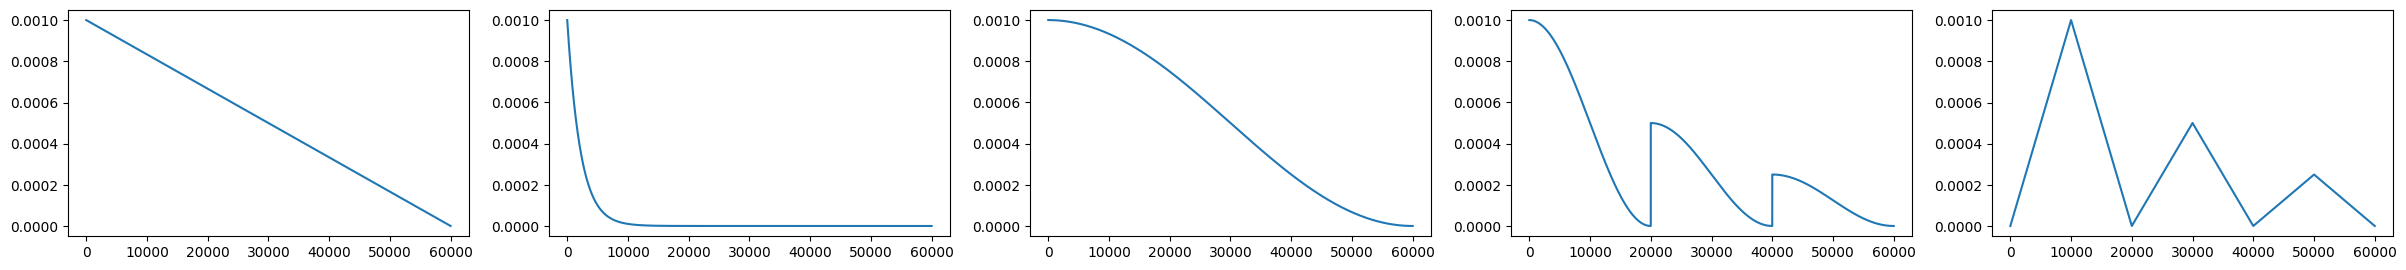

In [4]:
plt.rcParams['figure.figsize'] = [30, 3]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower
epochs = 12
spe = 5000
lin = PolynomialDecay(0.001, epochs*spe, 1e-6)
ed = ExponentialDecay(0.001, spe, 0.1)
cd = CosineDecay(0.001, epochs*spe, alpha=0.0)
cdr = CosineDecayRestarts(0.001,
                          first_decay_steps=4*spe,
                          t_mul=1.0,
                          m_mul=0.5,
                          alpha=1e-6)
tclr = Triangular2CyclicalLearningRate(1e-6, 0.001, 2*spe)
 
steps = np.arange(0, epochs*spe)
imgs = np.array([sc(steps) for sc in [lin, ed, cd, cdr, tclr]])
fig, ax = plt.subplots(1, 5)
for i, j in enumerate(imgs):
    ax[i].plot(steps, j)

## Find optimal learning rate range

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 72, 32, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 72, 32, 16)        160       
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 32, 16)        2320      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 36, 16, 16)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 36, 16, 32)        4640      
                                                                 
 conv2d_3 (Conv2D)           (None, 36, 16, 32)        9248      
                                                             

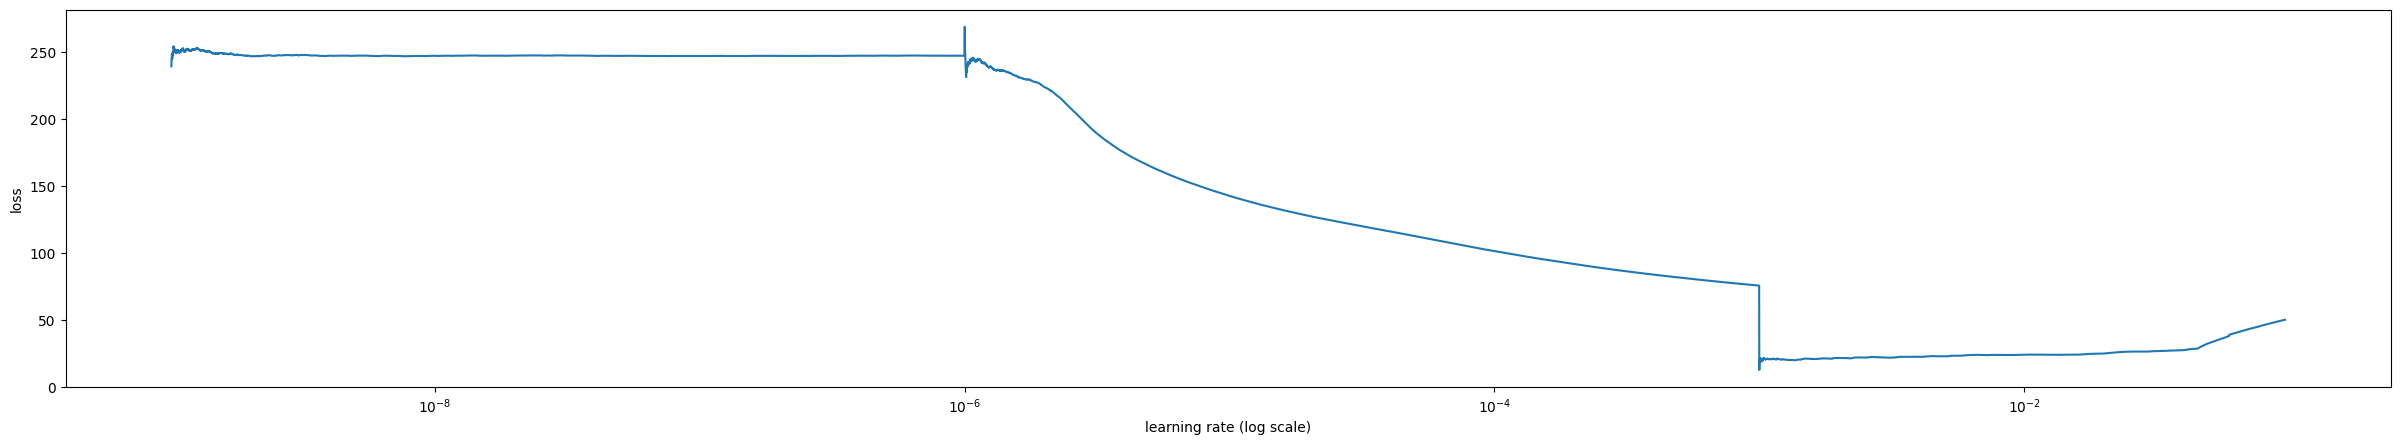

2022-04-12 16:27:49.425436: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8302


In [5]:
from keras_lr_finder import LRFinder
model = plain_net_wo_conf(ins, os)
plt.rcParams['figure.figsize'] = [30, 5]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower

#lr = CyclicalLearningRate(config.init_lr, config.max_lr, scale_fn=lambda x: 1/(2.**(x-1)), step_size=3*config.spe)
lr = 0.001
opt= Adam(lr)
model.compile(optimizer=opt, loss="mse", metrics=["accuracy"])

lr_finder = LRFinder(model)
lr_finder.find(x_train, y_train, start_lr=1e-9, end_lr=1, batch_size=32, epochs=3)
lr_finder.plot_loss(n_skip_end=1)
plt.show()